In [1]:
import os
import shutil
import natsort
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,MaxPooling2D

<h1>Training data preparation

We are reading the csv dataset which has the class label information. Once we add the label column as a numberical value to the train dataframe, we can create individual folders for each class.

In [2]:
data_dir = r'D:\Project\foliar_disease\original_data\images'
train_df = pd.read_csv(r"D:\Project\foliar_disease\original_data\train.csv") 
test_df = pd.read_csv(r"D:\Project\foliar_disease\original_data\train.csv")

In [3]:
# Adding label column to the train_df
class_df = pd.DataFrame(train_df,columns=['healthy','multiple_diseases','rust','scab'])
train_df['label'] = 0
num = 0
for i in class_df:
    train_df['label'] = train_df['label'] + train_df[i] * num
    num+=1

In [4]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [5]:
# Creating folders for each class
shutil.os.mkdir(r'D:\Project\foliar_disease\images')
shutil.os.mkdir(r'D:\Project\foliar_disease\images\train')

shutil.os.mkdir(r'D:\Project\foliar_disease\images\train\healthy')
shutil.os.mkdir(r'D:\Project\foliar_disease\images\train\multiple_disease')
shutil.os.mkdir(r'D:\Project\foliar_disease\images\train\rust')
shutil.os.mkdir(r'D:\Project\foliar_disease\images\train\scab')

shutil.os.mkdir(r'D:\Project\foliar_disease\images\test')

In [6]:
def create_train_data():
    images=natsort.natsorted(os.listdir(data_dir))
    for img in tqdm(images):
        path=os.path.join(data_dir,img)
        
        if "Train" in img:
            img=img.split('.')[0]
            label=train_df.loc[train_df['image_id']==img]['label']
            img_id = img.split("_")[1]
            if img_id and label.item()==0:
                shutil.copy(path,r'D:\Project\foliar_disease\images\train\healthy')
            
            elif img_id and label.item()==1:
                shutil.copy(path,r'D:\Project\foliar_disease\images\train\multiple_disease')
                
            elif img_id and label.item()==2:
                shutil.copy(path,r'D:\Project\foliar_disease\images\train\rust')
                
            elif img_id and label.item()==3:
                shutil.copy(path,r'D:\Project\foliar_disease\images\train\scab')
                
        elif "Test" in img:
            shutil.copy(path,r'D:\Project\foliar_disease\images\test')

In [7]:
# Copying images to respective folders
train_dir=create_train_data()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2122/2122 [00:42<00:00, 49.99it/s]


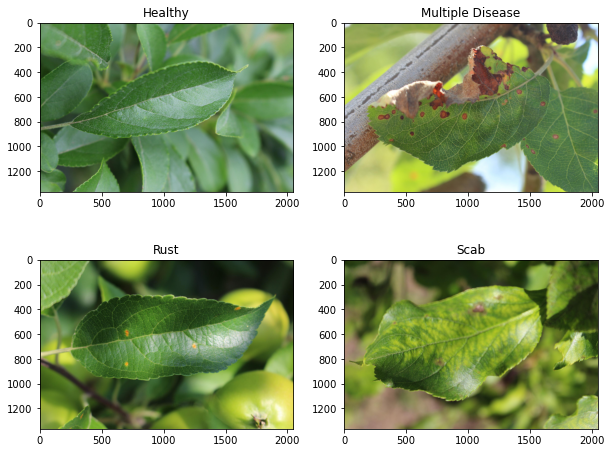

In [8]:
# Sample Training Images from all classes
class_map = {"healthy": "Healthy", "multiple_disease": "Multiple Disease", "rust": "Rust", "scab": "Scab"}
train_dir=r'D:\Project\foliar_disease\images\train'
plt.figure(figsize = (10, 8))
image_count = 1
for dir in os.listdir(train_dir):
    if dir[0] != '.':
        for i, file in enumerate(os.listdir(train_dir + '\\' + dir)):
            if i == 1:
                break
            else:
                fig = plt.subplot(2, 2, image_count)
                image_count += 1
                image = mpimg.imread(train_dir + '\\' + dir + '\\' + file)
                plt.imshow(image)
                plt.title(class_map[dir])

<h3>Data Preprocessing

1. Reducing the size of images to (224,224) due to resource constraint(No GPU).
2. The above mentioned image dimensions will ensure to give the best results even though its reduced by a factor of 10x.
3. Spliting the data set into test and validations sets for model training.

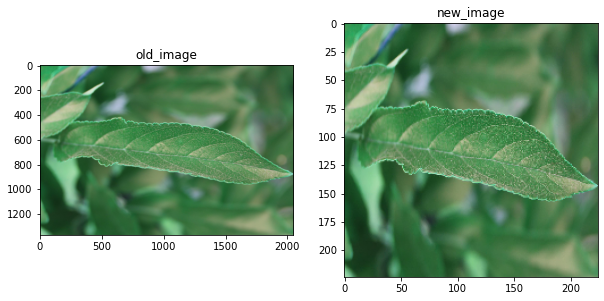

In [9]:
IMG_SIZE=224

sample_img_path = r'D:\Project\foliar_disease\images\train\healthy\Train_4.jpg'
old_image=cv2.imread(sample_img_path,cv2.COLOR_BGR2RGB)
new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.figure(figsize = (10, 10))
i=0
image_label_map = {"0": "old_image", "1": "new_image"}
for img in [old_image,new_image]:
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(image_label_map[str(i)])
    i+=1

In [10]:
datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)


train_datagen=datagen.flow_from_directory(r'D:\Project\foliar_disease\images\train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='training')
val_datagen=datagen.flow_from_directory(r'D:\Project\foliar_disease\images\train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='validation')

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


<h1>Model

In [11]:
# Model Structure
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(4,activation='softmax'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [12]:
# Checkpoints
checkpoint=ModelCheckpoint(r'D:\Project\foliar_disease\models\apple2.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [13]:
# Running the Model
model_history=model.fit_generator(train_datagen,validation_data=val_datagen,
                                 epochs=30,
                                 steps_per_epoch=train_datagen.samples//16,
                                 validation_steps=val_datagen.samples//16,
                                 callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
91/91 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.3190
Epoch 00001: val_loss improved from inf to 1.24686, saving model to D:\Project\foliar_disease\models\apple2.h5
91/91 [==============================] - 216s 2s/step - loss: 1.2730 - accuracy: 0.3190 - val_loss: 1.2469 - val_accuracy: 0.3409
Epoch 2/30
91/91 [==============================] - ETA: 0s - loss: 1.2462 - accuracy: 0.3558
Epoch 00002: val_loss did not improve from 1.24686
91/91 [==============================] - 184s 2s/step - loss: 1.2462 - accuracy: 0.3558 - val_loss: 1.5847 - val_accuracy: 0.3409
Epoch 3/30
91/91 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.3356
Epoch 00003: val_loss improved from 1.24686 to 1.23808, saving model to D:\Project\foliar_disease\models\apple2.h5
91/91 [==============================] - 220s 2s/step - loss: 1.2522 - accuracy: 0.3356 - val_loss: 1.238

Epoch 26/30
91/91 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.8696
Epoch 00026: val_loss improved from 0.39276 to 0.38053, saving model to D:\Project\foliar_disease\models\apple2.h5
91/91 [==============================] - 152s 2s/step - loss: 0.3877 - accuracy: 0.8696 - val_loss: 0.3805 - val_accuracy: 0.8722
Epoch 27/30
91/91 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8779
Epoch 00027: val_loss improved from 0.38053 to 0.34832, saving model to D:\Project\foliar_disease\models\apple2.h5
91/91 [==============================] - 172s 2s/step - loss: 0.3541 - accuracy: 0.8779 - val_loss: 0.3483 - val_accuracy: 0.8892
Epoch 28/30
91/91 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8814
Epoch 00028: val_loss did not improve from 0.34832
91/91 [==============================] - 190s 2s/step - loss: 0.3531 - accuracy: 0.8814 - val_loss: 0.3842 - val_accuracy: 0.8665
Epoch 29/30
91/91 [=========================

<h3>Accuracy & Loss Plots

The validation set accuracy is **~90%**. <br>This infers that the model has trained well but the class distribution of the training dataset is uneven. CNNs are known to perform well when the class distribution is even. Hence this result could have been better if the training sets had an even class distribution.

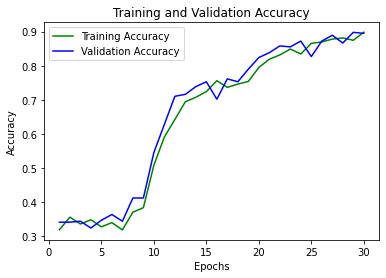

In [14]:
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(1,31)
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

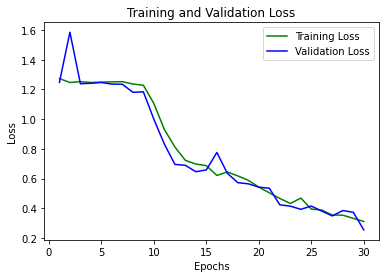

In [15]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1,31)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

<h3>Testing the model on Test Data

In the 1st Test case, We are taking a train image to check the model's correctness.<br>
In the 2nd test case, We are considering an actual test image for prediction to validate the prediction accuracy.

In [28]:
from tensorflow.keras.preprocessing import image

In [29]:
class_map = {"0": "Healthy", "1": "Multiple Disease", "2": "Rust", "3": "Scab"}
def predict(test_image):
    test_image = image.load_img(test_image,target_size=(224,224))
    test_image = image.img_to_array(test_image)
    test_image = test_image/255
    test_image = np.expand_dims(test_image,axis=0)
    prediction = model.predict(test_image)
    result = np.argmax(prediction)
    return [str(result),class_map[str(result)]]

Predicted Class:  ['3', 'Scab']


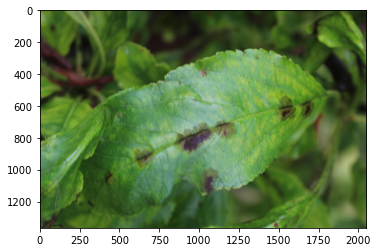

In [30]:
test_image = r'D:\Project\foliar_disease\images\train\scab\Train_78.jpg'
print("Predicted Class: ", predict(test_image))

display_image=Image.open(test_image)
plt.imshow(display_image)

Predicted Class:  ['0', 'Healthy']


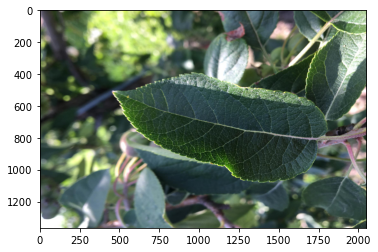

In [31]:
test_image = r'D:\Project\foliar_disease\images\test\Test_132.jpg'
print("Predicted Class: ", predict(test_image))

display_image=Image.open(test_image)
plt.imshow(display_image)

<h3>Inferences

1. In the 1st test case, We took a image that belongs to "Scab" class. The model was able to predict the image that it belongs to the Scab class which proves the model's correctness.<br> 
2. In the 2nd test case, the model was given a test input image. It was able to predict the image belongs to "Healthy" class which is evident from the test image.